# Analyzing NO₂ Pollution Trends in India: A 5-Year Study (2020-2024)

In [1]:
from os import getenv
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubStatisticalDownloadClient,
    SentinelHubRequest,
    SentinelHubStatistical,
    parse_time
)

In [2]:
config = SHConfig()
config.sh_client_id = getenv('sh_client_id')
config.sh_client_secret = getenv('sh_client_secret')
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

### Spatial Distribution Analysis

This section provides an overview of the Indian region covered in this study. We begin by defining the bounding coordinates for mainland India. To obtain NO₂ concentration data. We will use measurements from the [Sentinel-5P](https://www.eoportal.org/satellite-missions/copernicus-sentinel-5p#eop-quick-facts-section) satellite, which provides detailed information on trace gases, including NO₂ mole fraction, along with other atmospheric parameters such as aerosol absorption and ozone concentration.

In [3]:
india_coords = [65.994234,6.055407,98.340165,37.101950]
bbox = BBox(bbox=india_coords , crs=CRS.WGS84).transform(CRS(3857))
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

In [4]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [5]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2024-11-01", "2024-11-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=(5000, 3500),
    config=config,
    data_folder="./data",
)

In [6]:
mean_data = request_monthly.get_data(save_data=True, show_progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
countries = (
    gpd.read_file("./data/ne_10m_admin_0_countries_ind/ne_10m_admin_0_countries_ind.shp")
    .to_crs(3857)
    .cx[bbox.min_x : bbox.max_x, bbox.min_y : bbox.max_y]
    .reset_index(drop=True)
)
states_provinces = (
    gpd.read_file("./data/ne_10m_admin_1_states_provinces_lines/ne_10m_admin_1_states_provinces_lines.shp")
    .to_crs(3857)
    .cx[bbox.min_x : bbox.max_x, bbox.min_y : bbox.max_y]
    .reset_index(drop=True)
)
states_provinces = states_provinces[states_provinces.ADM0_A3 == "IND"]

def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")
        states_provinces.plot(ax=ax, facecolor="none", edgecolor="black")

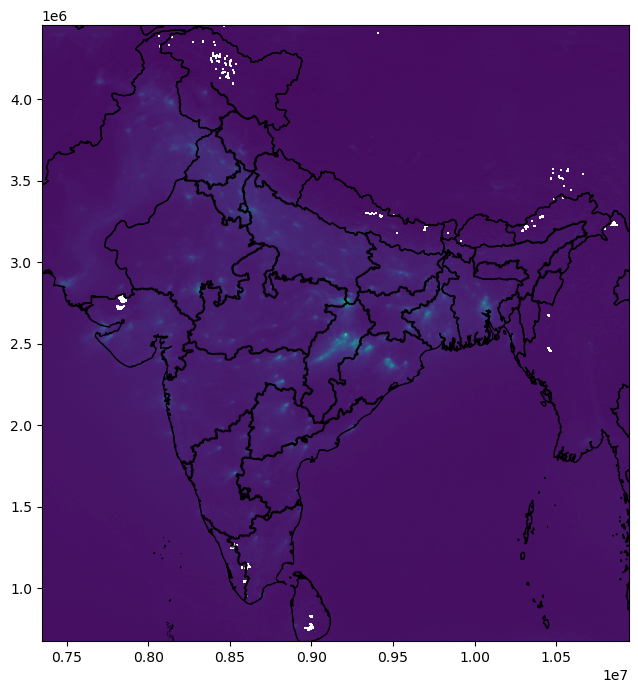

In [8]:
plot_request(request_monthly, bbox)

For getting an overview, we have considered NO₂ levels for the month of November 2024.
It can be observed that the values are concentrated over few cities and for the majority of the region, levels are comparitively lower. 

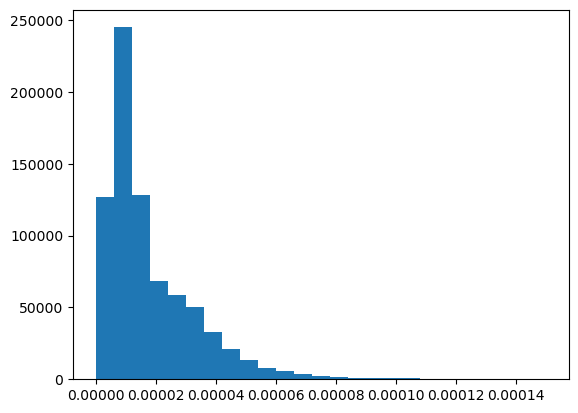

In [9]:
plt.stairs(*np.histogram(mean_data[0], range=(0, 0.00015), bins=25), fill=True);

### Sentinel-5P Data Request and Yearly Statistical Analysis

Now, we define an evaluation script to extract NO₂ data from Sentinel-5P imagery. The script specifies the input bands ("NO2" and "dataMask") and sets the output configuration with NO₂ values as FLOAT32 and a data mask for valid data pixels. The `isClear()` function filters out cloudy or invalid pixels, while the `sum()` function calculates the total NO₂ levels. The `evaluatePixel()` function calculates the mean NO₂ concentration for clear pixels.

In [10]:
evalscript_stat = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: [{ 
          id: "default",
          bands: ["NO2"],
          sampleType: "FLOAT32" 
        },
        { 
          id: "dataMask",
          bands: 1,
        }],
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return {default: [mean], dataMask: [clearTs.length]}
}
"""

In [11]:
input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)
)

requests = []


To analyze the NO₂ pollution over the years, we create a request for each year from 2020 to 2024. Specifically, the years analyzed are **2020**, **2021**, **2022**, **2023**, and **2024**. For each year, we define the start and end dates, then request daily aggregated NO₂ data for the entire year using the defined evaluation script. This yearly breakdown allows for a detailed comparison of NO₂ levels across these years.


The requests are compiled into a list, and the data is downloaded using the `SentinelHubStatisticalDownloadClient`, which facilitates efficient multi-threaded downloading of the pollution statistics for each year.


In [12]:
years = range(2020, 2025)

In [13]:
for year in years:
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(
            evalscript=evalscript_stat,
            time_interval=(start_date, end_date),
            aggregation_interval="P1D",
            size=(1, 1),
            ),
        input_data=[input_data],
        bbox=bbox,
        config=config,
    )
    requests.append(request)

download_requests = [request.download_list[0] for request in requests]

client = SentinelHubStatisticalDownloadClient(config=config)
pollution_stats = client.download(download_requests, max_threads=5, show_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

This helper function converts the output from the statistical API into a pandas dataframe.

In [14]:
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

In [15]:
no2_dfs = [stats_to_df(polygon_stats) for polygon_stats in pollution_stats]

no2_df = pd.concat(no2_dfs)
no2_df["year"] = no2_df["interval_from"].astype("datetime64[ns]").dt.year
no2_df["month"] = no2_df["interval_from"].astype("datetime64[ns]").dt.month
no2_df.to_csv("./data/no2_timeseries_raw.csv")


Now that we have our data, we can start with the analysis. However, since the analysis is being performed in the first week of December, we don't have complete data for the month of December (2024). As we will be looking at the monthly analysis for all years, we need to estimate these values.

### Estimating Missing NO₂ Data for December 2024

**Objective**  
Since we have data for only 2 days (4th and 5th December) of December 2024, we will estimate the missing data for the remaining days (6th–31st December) using historical daily averages for December from the years 2020–2023.

**Process**  
1. Filter Historical December Data: Extract NO₂ data for December from 2020 to 2023.  
2. Compute Daily Averages: Calculate the average daily NO₂ values (`default_NO2_mean`, etc.) across these years.  
3. Generate Missing Days: Create a DataFrame for the missing dates (6th–31st December 2024).  
4. Assign Estimated Values: Use the historical daily averages to populate NO₂ metrics for these missing dates.  
5. Update the Original DataFrame: Append the estimated data to the existing `no2_df`.

This ensures continuity in the dataset for accurate year-month-wise analysis.

In [16]:
# Note: Run only once.

# Step 1: Filter December data from 2020 to 2023
december_data = no2_df[(no2_df['month'] == 12) & (no2_df['year'] < 2024)]

# Step 2: Calculate daily averages for December
daily_avg = december_data.groupby(['year', 'interval_from']).agg({
    'default_NO2_min': 'mean',
    'default_NO2_max': 'mean',
    'default_NO2_mean': 'mean',
    'default_NO2_stDev': 'mean',
    'default_NO2_sampleCount': 'mean',
    'default_NO2_noDataCount': 'mean'
}).reset_index()

# Compute overall averages for daily values in December (2020-2023)
avg_december_daily = daily_avg.groupby('interval_from').mean().reset_index()

# Step 3: Generate missing days for December 2024
missing_days = pd.date_range(start="2024-12-06", end="2024-12-31").date

# Step 4: Assign Estimated Values
missing_data = pd.DataFrame({
    'interval_from': missing_days,
    'interval_to': missing_days,
    'default_NO2_min': avg_december_daily['default_NO2_min'].values[:len(missing_days)],
    'default_NO2_max': avg_december_daily['default_NO2_max'].values[:len(missing_days)],
    'default_NO2_mean': avg_december_daily['default_NO2_mean'].values[:len(missing_days)],
    'default_NO2_stDev': avg_december_daily['default_NO2_stDev'].values[:len(missing_days)],
    'default_NO2_sampleCount': avg_december_daily['default_NO2_sampleCount'].values[:len(missing_days)],
    'default_NO2_noDataCount': avg_december_daily['default_NO2_noDataCount'].values[:len(missing_days)],
    'year': 2024,
    'month': 12
})

# Step 5: Append the missing data to the original dataframe
no2_df = pd.concat([no2_df, missing_data], ignore_index=True)

no2_df.to_csv("./data/no2_timeseries_with_estimation.csv")

no2_df



,interval_from,interval_to,default_NO2_min,default_NO2_max,default_NO2_mean,default_NO2_stDev,default_NO2_sampleCount,default_NO2_noDataCount,year,month
0,2020-01-07,2020-01-07,0.000026,0.000026,0.000026,0.0,1.0,0.0,2020,1
1,2020-01-12,2020-01-12,0.000044,0.000044,0.000044,0.0,1.0,0.0,2020,1
2,2020-01-13,2020-01-13,0.000010,0.000010,0.000010,0.0,1.0,0.0,2020,1
3,2020-01-18,2020-01-18,0.000020,0.000020,0.000020,0.0,1.0,0.0,2020,1
4,2020-01-28,2020-01-28,0.000019,0.000019,0.000019,0.0,1.0,0.0,2020,1
...,...,...,...,...,...,...,...,...,...,...
672,2024-12-27,2024-12-27,0.000143,0.000143,0.000143,0.0,1.0,0.0,2024,12
673,2024-12-28,2024-12-28,0.000101,0.000101,0.000101,0.0,1.0,0.0,2024,12
674,2024-12-29,2024-12-29,0.000167,0.000167,0.000167,0.0,1.0,0.0,2024,12
675,2024-12-30,2024-12-30,0.000105,0.000105,0.000105,0.0,1.0,0.0,2024,12


Now, the dataset is complete, and we can continue with our analysis, focusing on visualizing the trends in NO₂ levels across different years and months. The heatmap will allow us to easily identify patterns, seasonal variations, and any significant changes in air quality over time.

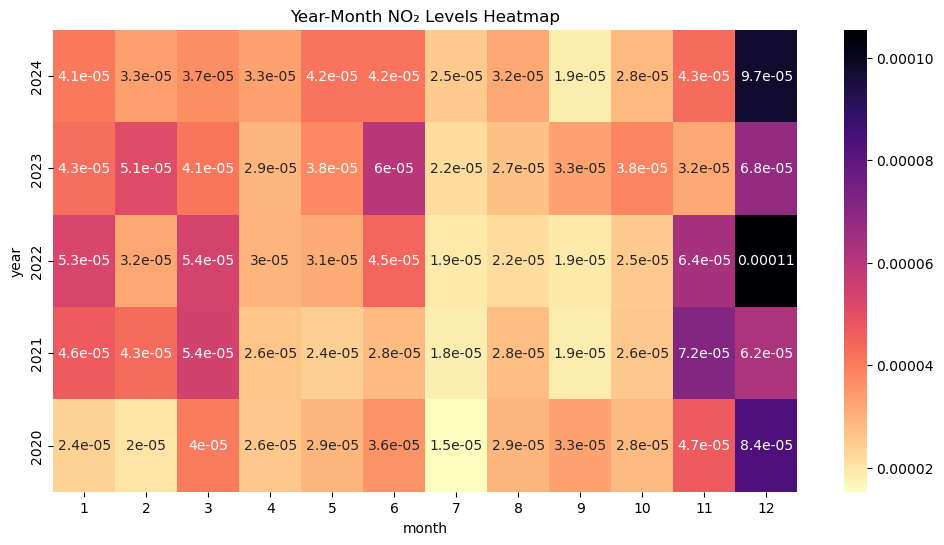

In [17]:
plt.figure(figsize=(12, 6))

pivot_table = no2_df.pivot_table(index='year', columns='month', values='default_NO2_mean', aggfunc='mean')
ax = sns.heatmap(pivot_table, 
                 cmap="magma_r", 
                 annot=True) 
ax.invert_yaxis()
plt.title("Year-Month NO₂ Levels Heatmap")
plt.show()

We can see that the 12th month of almost every year witnesses a hike in values, with lower levels and varying concentrations of NO₂ throughout the other months. To gain more insights, let's look at both year-wise and month-wise analysis.

### Analysing NO₂ levels Yearly

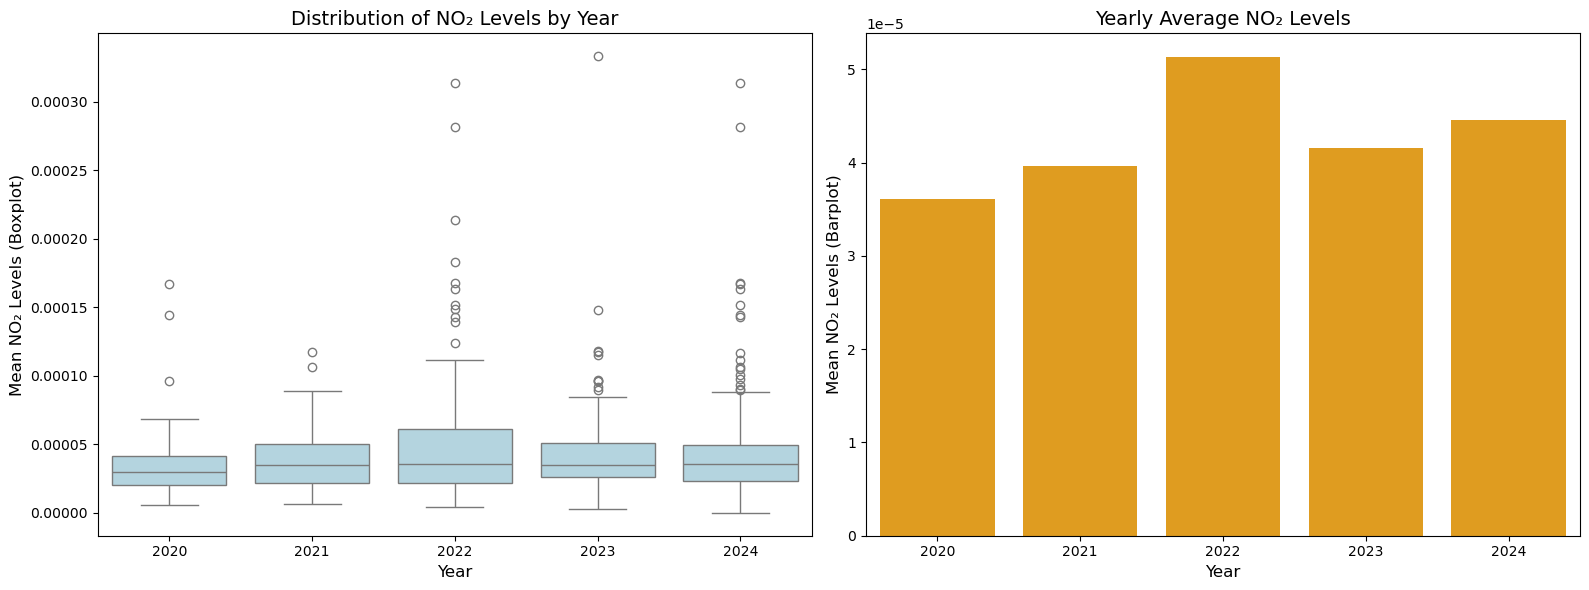

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

sns.boxplot(
    x="year", 
    y="default_NO2_mean", 
    data=no2_df.loc[no2_df["year"].isin(years)], 
    ax=axes[0], 
    color='lightblue'
)
axes[0].set_title("Distribution of NO₂ Levels by Year", fontsize=14)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Mean NO₂ Levels (Boxplot)", fontsize=12)

yearly_avg = no2_df.groupby('year')['default_NO2_mean'].mean().reset_index()
sns.barplot(
    data=yearly_avg, 
    x='year', 
    y='default_NO2_mean', 
    ax=axes[1], 
    color='orange'
)
axes[1].set_title("Yearly Average NO₂ Levels", fontsize=14)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Mean NO₂ Levels (Barplot)", fontsize=12)

plt.tight_layout()
plt.show()


This shows that although the mean NO₂ levels across all years are nearly the same, 2022 saw the highest average levels. Additionally, the values in 2021 were the lowest compared to other years, suggesting a potential link to the COVID-19 lockdown.

### Impact of Key Events

**COVID-19 Lockdown**: Examining the impact of the 2020 lockdowns on NO₂ levels in 2020 compared to other years.

In [19]:
lockdown_period = no2_df[(no2_df['year'] == 2020) & (no2_df['month'].isin(range(1,13)))]
comparison = no2_df[(no2_df['year'] != 2020) & (no2_df['month'].isin(range(1,13)))]
print("Lockdown Period Averages:", lockdown_period['default_NO2_mean'].mean())
print("Other Period Averages:", comparison['default_NO2_mean'].mean())

Lockdown Period Averages: 3.610331641714136e-05
Other Period Averages: 4.448831175168379e-05


We can see that the NO₂ levels in the Lockdown period are lesser compared to other years. It could be because of reduced vehicular and industrial emissions. Now, let's move forward to month-wise analysis for even stronger insights.


### Analysing NO₂ levels Monthly

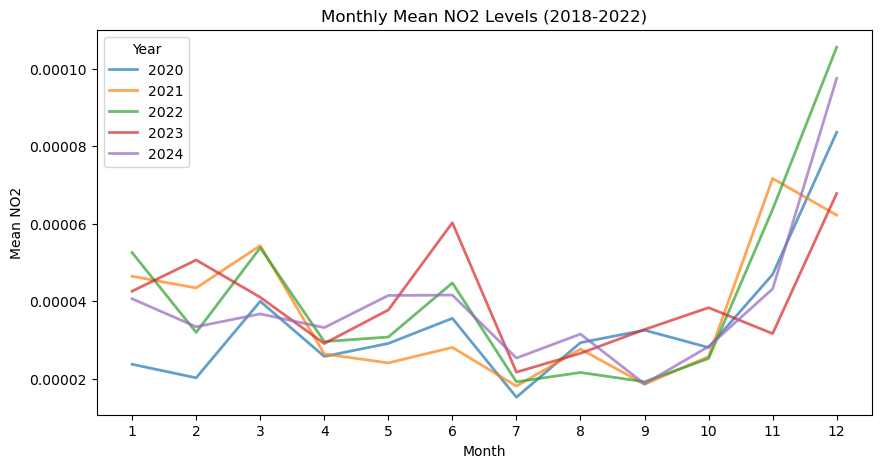

In [20]:
plt.figure(figsize=[10,5])
sns.lineplot(
    data=no2_df.loc[no2_df["year"].isin(years)],
    x="month",
    y="default_NO2_mean",
    hue="year",
    palette=sns.color_palette("tab10", 5),
    linewidth=2,
    alpha=0.7,
    errorbar = None
)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Mean NO2")
plt.title("Monthly Mean NO2 Levels (2018-2022)")
plt.legend(title="Year");

The above shows significant seasonal variations in NO₂ concentrations, with notable peaks during the summer (June) and winter (December) months. December, in particular, stands out, consistently recording the highest concentrations, reaching all-time peaks.
These seasonal fluctuations suggest a potential link to factors such as temperature, industrial activity, and vehicular emissions, which are likely contributing to the elevated pollution levels during these periods.  

Such trends underscore the need for targeted interventions to mitigate NO₂ pollution, particularly during these high-risk months.